## Image sample (DDPM - guided diffusion - Diffusion beats gans)

In [1]:
# from __future__ import print_function 
import argparse
import os, sys, glob

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import torch.distributed as dist
import datetime
from collections import namedtuple
sys.path.insert(0, '../')
import deca_dpm
from guided_diffusion.script_util import (
    model_and_diffusion_defaults,
    create_deca_and_diffusion,
    add_dict_to_argparser,
    args_to_dict,
    seed_all,
    diffusion_defaults,
)

In [2]:
def create_argparser(log_dir, deca_model_path,**kwargs):
    defaults = dict(
        clip_denoised=True,
        num_samples=1,
        batch_size=10,
        use_ddim=False,
        deca_model_path=deca_model_path,
        log_dir=log_dir,
        diffusion_step=250,
        timestep_respacing=250,
        deca_cond=False,
        bound=1,
        num_layers=3,
    )

    defaults.update(model_and_diffusion_defaults())
    return namedtuple('GenericDict', defaults.keys())(**defaults)

def model_and_diffusion_defaults():
    """
    Defaults for image training.
    """
    res = dict(
        num_channels=128,
        num_res_blocks=2,
        num_heads=4,
        num_heads_upsample=-1,
        num_head_channels=-1,
        attention_resolutions="16,8",
        channel_mult="",
        dropout=0.0,
        class_cond=False,
        use_checkpoint=False,
        use_scale_shift_norm=True,
        resblock_updown=False,
        use_new_attention_order=False,
        deca_cond=False,
        num_layers=3,
    )
    res.update(diffusion_defaults())
    return res

In [3]:
# List model_logs
ct = ""
# sshfs_path = "/home/mint/mnt_tl_puntawat-ms-7c37/home/puntawat/Mint/Work/Vision/Diffusion/mount/"
sshfs_path = "/data/mint/model_logs/"
model_logs_path = f"{sshfs_path}/{ct}/"

# args
log_dir = "magenta"

step = "015000"
# step = "150000"
# ckpt = f"model{step}"
ckpt = f"ema_0.9999_{step}"
deca_model_path = f"{model_logs_path}/{log_dir}/Deca_{ckpt}.pt"

args = create_argparser(log_dir=log_dir, deca_model_path=deca_model_path)

# Check model_logs
if not os.path.isdir(os.path.join(model_logs_path, args.log_dir)):
    print("No logs folder")
    raise FileNotFoundError
else: 
    if not os.path.isdir(os.path.join(model_logs_path, args.log_dir, "samples")):
        os.makedirs(os.path.join(model_logs_path, args.log_dir, "samples"))

model_and_diffusion = model_and_diffusion_defaults()

deca_model, diffusion = create_deca_and_diffusion(
    **args_to_dict(args, model_and_diffusion.keys())
)

deca_model.load_state_dict(
    th.load(args.deca_model_path, map_location="cpu")
)

deca_model.to('cuda')
deca_model.eval()



DenseDDPM(
  (in_layers): Linear(in_features=159, out_features=2048, bias=True)
  (mid_layers): ModuleList(
    (0): Sequential(
      (0): DenseFiLM(
        (time_embed): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): SiLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
        )
        (scale_layer): Linear(in_features=512, out_features=2048, bias=True)
        (shift_layer): Linear(in_features=512, out_features=2048, bias=True)
      )
      (1): DenseResBlock(
        (resblock): Sequential(
          (0): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
          (1): FeaturewiseAffine()
          (2): SiLU()
          (3): Linear(in_features=2048, out_features=2048, bias=True)
          (4): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
          (5): FeaturewiseAffine()
          (6): SiLU()
          (7): Linear(in_features=2048, out_features=2048, bias=True)
        )
      )
    )
    (1): 

In [4]:
def decolor(s, out_c='rgb'):
    if out_c in ['rgb', 'rbg', 'brg', 'bgr', 'grb', 'gbr']:
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)
    elif out_c == 'luv':
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)
    elif out_c == 'ycrcb':
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)
    elif out_c in ['hsv', 'hls']:
        h = (s[..., [0]] + 1) * 90.0 
        l_s = (s[..., [1]] + 1) * 127.5
        v = (s[..., [2]] + 1) * 127.5
        s_ = th.cat((h, l_s, v), axis=2).clamp(0, 255).to(th.uint8)
    elif out_c == 'sepia':
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)

    else: raise NotImplementedError

    return s_

def plot_sample(img, **kwargs):
    columns = 6
    rows = 10
    fig = plt.figure(figsize=(20, 20), dpi=100)
    img = img.permute(0, 2, 3, 1) # BxHxWxC
    pt = 0
    for i in range(0, img.shape[0]):
        s_ = decolor(s=img[i], out_c='rgb')
        s_ = s_.detach().cpu().numpy()
        fig.add_subplot(rows, columns, pt+1)
        plt.imshow(s_)
        pt += 1

        if kwargs is not None:
            # Plot other images
            for k in kwargs:
                fig.add_subplot(rows, columns, pt+1)
                s_ = decolor(s=kwargs[k][i].permute(1, 2, 0), out_c='rgb')
                s_ = s_.detach().cpu().numpy()
                plt.imshow(s_)
                pt += 1
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.65, 
                        top=0.9, 
                        wspace=0.1, 
                        hspace=0.2)
    plt.show()

def plot_deca(sample):

    img_ = []
    from tqdm.auto import tqdm
    for i in tqdm(range(sample['deca_output'].shape[0])):
        deca_params = sample['deca_output'][i].clone()
        deca_params = denormalize(deca_params, min_val=th.tensor(min_val).cuda(), max_val=th.tensor(max_val).cuda(), a=-args.bound, b=args.bound).float()
        shape = deca_params[None, :100]
        pose = deca_params[None, 100:106]
        exp = deca_params[None, 106:156]
        cam = deca_params[None, 156:]
        img = params_to_model(shape=shape, exp=exp, pose=pose, cam=cam, i=i)
        img_.append(img["shape_images"])

    plot_sample(th.cat(img_, dim=0))
        

In [5]:
from ast import Expression, arg, parse
from pickle import PickleError
import argparse
import numpy as np
import pandas as pd
import torch as th
import torch.nn.functional as F
import glob, os
import PIL
import matplotlib.pyplot as plt
from model_3d.FLAME import FLAME
from model_3d.FLAME.config import cfg as flame_cfg
from collections import defaultdict
from model_3d.FLAME.utils.renderer import SRenderY
import model_3d.FLAME.utils.util as util
import model_3d.FLAME.utils.detectors as detectors
from skimage.io import imread, imsave
from skimage.transform import estimate_transform, warp, resize, rescale

flame = FLAME.FLAME(flame_cfg.model).cuda()

def params_to_model(shape, exp, pose, cam, i, uvdn=None):
    verts, landmarks2d, landmarks3d = flame(shape_params=shape, 
            expression_params=exp, 
            pose_params=pose)
    renderer = SRenderY(image_size=256, obj_filename=flame_cfg.model.topology_path, uv_size=flame_cfg.model.uv_size).cuda()

    ## projection
    landmarks2d = util.batch_orth_proj(landmarks2d, cam)[:,:,:2]; landmarks2d[:,:,1:] = -landmarks2d[:,:,1:]#; landmarks2d = landmarks2d*self.image_size/2 + self.image_size/2
    landmarks3d = util.batch_orth_proj(landmarks3d, cam); landmarks3d[:,:,1:] = -landmarks3d[:,:,1:] #; landmarks3d = landmarks3d*self.image_size/2 + self.image_size/2
    trans_verts = util.batch_orth_proj(verts, cam); trans_verts[:,:,1:] = -trans_verts[:,:,1:]

    ## rendering
    shape_images = renderer.render_shape(verts, trans_verts)

    opdict = {'verts' : verts,}

    os.makedirs('./rendered_obj', exist_ok=True)
    save_obj(renderer=renderer, filename=(f'./rendered_obj/{i}.obj'), opdict=opdict)
    
    return {"shape_images":shape_images, "landmarks2d":landmarks2d, "landmarks3d":landmarks3d}

def save_obj(renderer, filename, opdict):
    '''
    vertices: [nv, 3], tensor
    texture: [3, h, w], tensor
    '''
    i = 0
    vertices = opdict['verts'][i].cpu().numpy()
    faces = renderer.faces[0].cpu().numpy()
    colors = np.ones(shape=vertices.shape) * 127.5

    # save coarse mesh
    util.write_obj(filename, vertices, faces, colors=colors)

def read_params(path):
    params = pd.read_csv(path, header=None, sep=" ", index_col=False, lineterminator='\n')
    params.rename(columns={0:'img_name'}, inplace=True)
    params = params.set_index('img_name').T.to_dict('list')
    return params

def swap_key(params):
    params_s = defaultdict(dict)
    for params_name, v in params.items():
        for img_name, params_value in v.items():
            params_s[img_name][params_name] = np.array(params_value).astype(np.float64)

    return params_s

def normalize(arr, min_val=None, max_val=None, a=-1, b=1):
    '''
    Normalize any vars to [a, b]
    :param a: new minimum value
    :param b: new maximum value
    :param arr: np.array shape=(N, #params_dim) e.g. deca's params_dim = 159
    ref : https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
    '''
    if max_val is None and min_val is None:
        max_val = np.max(arr, axis=0)    
        min_val = np.min(arr, axis=0)

    arr_norm = ((b-a) * (arr - min_val) / (max_val - min_val)) + a
    return arr_norm, min_val, max_val

def denormalize(arr_norm, min_val, max_val, a=-1, b=1):
    arr_denorm = (((arr_norm - a) * (max_val - min_val)) / (b - a)) + min_val
    return arr_denorm

# Load params 
params_key = ['shape', 'pose', 'exp', 'cam']
anno_path = glob.glob(f'/data/mint/ffhq_256_with_anno/params/*.txt')
params = {}
for k in params_key:
    for p in anno_path:
        # Params
        if k in p:
            print(f'Key=> {k} : Filename=>{p}')
            params[k] = read_params(path=p)

params_s = swap_key(params)

all_params = []
for img_name in params_s:
    each_img = []
    for k in params_key:
        each_img.append(params_s[img_name][k])
    all_params.append(np.concatenate(each_img))
all_params = np.stack(all_params)
_, min_val, max_val = normalize(a=-args.bound, b=args.bound, arr=all_params)

creating the FLAME Decoder
Key=> shape : Filename=>/data/mint/ffhq_256_with_anno/params/ffhq-train-shape-anno.txt
Key=> pose : Filename=>/data/mint/ffhq_256_with_anno/params/ffhq-train-pose-anno.txt
Key=> exp : Filename=>/data/mint/ffhq_256_with_anno/params/ffhq-train-exp-anno.txt
Key=> cam : Filename=>/data/mint/ffhq_256_with_anno/params/ffhq-train-cam-anno.txt


In [6]:
# Sampling
import pytorch_lightning as pl
class PLInference(pl.LightningModule):
    def __init__(self, deca_model, sample_fn):
        super(PLInference, self).__init__()
        self.deca_model = deca_model
        self.sample_fn = sample_fn
        self.deca_dpm = deca_dpm.Diffusion_DECA(model=self.deca_model, diffusion=diffusion, bound=args.bound, progress=True)

    def forward(self, shape_dict, noise=None):
        '''
        :noise: in B x N-dim
        '''
        if self.sample_fn == 'p_sample_loop':
            deca_output = self.deca_dpm.p_sample_loop(
                                        shape_dict=shape_dict,
                                        noise={'deca':noise})

        return {"deca_output":deca_output}


In [7]:
# Normal Sampling 
# seed_all(33)
init_noise = th.randn((1, 159)).cuda()
# init_noise = th.cat(([th.randn((1, 159)).cuda()] * args.batch_size), dim=0)
pl_inference = PLInference(deca_model=deca_model, sample_fn='p_sample_loop')
sample = pl_inference(shape_dict={'deca':(init_noise.shape[0], 159)}, noise=init_noise.clone())
plot_deca(sample)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

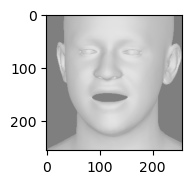

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

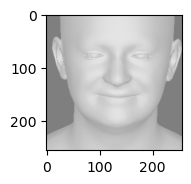

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Normal Sampling 
init_noise = th.randn((1, 159)).cuda()
# init_noise = th.cat(([th.randn((1, 159)).cuda()] * args.batch_size), dim=0)
for i in range(10):
    pl_inference = PLInference(deca_model=deca_model, sample_fn='p_sample_loop')
    sample = pl_inference(shape_dict={'deca':(init_noise.shape[0], 159)}, noise=init_noise.clone())
    plot_deca(sample)

tensor([[ 7.2335e-01,  6.5953e-03,  1.1785e+00, -7.6708e-01, -4.3508e-01,
         -6.3469e-01, -4.0231e-01,  9.6141e-01, -1.5626e+00, -2.2085e-01,
         -3.5860e-01,  1.3227e+00,  6.5684e-01,  1.3172e+00,  4.2810e-01,
         -2.8452e-04,  1.7369e-01,  8.3115e-01, -1.3930e+00, -2.4537e+00,
         -8.6764e-02,  1.1758e-01, -1.0630e-01, -2.2148e+00,  3.1309e-01,
          7.5372e-01, -5.1259e-01,  1.6882e+00, -1.5350e+00, -9.8279e-01,
         -1.3416e+00,  5.9776e-01, -1.0284e+00,  1.2132e+00, -1.6912e+00,
         -1.4658e+00,  1.0262e-01,  1.4117e+00,  2.3133e-01, -2.8162e-01,
          9.1848e-01, -3.4808e-01,  3.3335e-02,  7.8668e-01, -2.1424e+00,
         -1.2495e+00,  2.1901e+00, -1.9006e+00,  1.0311e+00,  1.8026e+00,
          4.4154e-01,  1.3285e-01, -4.3094e-02,  5.4936e-02, -8.2743e-01,
          6.3313e-01, -8.3702e-02, -8.8627e-01, -1.5460e+00, -1.3282e+00,
         -1.1794e+00,  1.3925e-01,  3.7281e-01,  2.8841e+00,  3.8582e-01,
         -1.4799e+00,  8.2325e-01,  1.

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

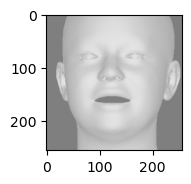

tensor([[ 7.2335e-01,  6.5953e-03,  1.1785e+00, -7.6708e-01, -4.3508e-01,
         -6.3469e-01, -4.0231e-01,  9.6141e-01, -1.5626e+00, -2.2085e-01,
         -3.5860e-01,  1.3227e+00,  6.5684e-01,  1.3172e+00,  4.2810e-01,
         -2.8452e-04,  1.7369e-01,  8.3115e-01, -1.3930e+00, -2.4537e+00,
         -8.6764e-02,  1.1758e-01, -1.0630e-01, -2.2148e+00,  3.1309e-01,
          7.5372e-01, -5.1259e-01,  1.6882e+00, -1.5350e+00, -9.8279e-01,
         -1.3416e+00,  5.9776e-01, -1.0284e+00,  1.2132e+00, -1.6912e+00,
         -1.4658e+00,  1.0262e-01,  1.4117e+00,  2.3133e-01, -2.8162e-01,
          9.1848e-01, -3.4808e-01,  3.3335e-02,  7.8668e-01, -2.1424e+00,
         -1.2495e+00,  2.1901e+00, -1.9006e+00,  1.0311e+00,  1.8026e+00,
          4.4154e-01,  1.3285e-01, -4.3094e-02,  5.4936e-02, -8.2743e-01,
          6.3313e-01, -8.3702e-02, -8.8627e-01, -1.5460e+00, -1.3282e+00,
         -1.1794e+00,  1.3925e-01,  3.7281e-01,  2.8841e+00,  3.8582e-01,
         -1.4799e+00,  8.2325e-01,  1.

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

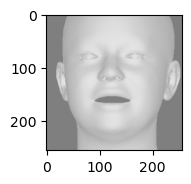

tensor([[ 7.2335e-01,  6.5953e-03,  1.1785e+00, -7.6708e-01, -4.3508e-01,
         -6.3469e-01, -4.0231e-01,  9.6141e-01, -1.5626e+00, -2.2085e-01,
         -3.5860e-01,  1.3227e+00,  6.5684e-01,  1.3172e+00,  4.2810e-01,
         -2.8452e-04,  1.7369e-01,  8.3115e-01, -1.3930e+00, -2.4537e+00,
         -8.6764e-02,  1.1758e-01, -1.0630e-01, -2.2148e+00,  3.1309e-01,
          7.5372e-01, -5.1259e-01,  1.6882e+00, -1.5350e+00, -9.8279e-01,
         -1.3416e+00,  5.9776e-01, -1.0284e+00,  1.2132e+00, -1.6912e+00,
         -1.4658e+00,  1.0262e-01,  1.4117e+00,  2.3133e-01, -2.8162e-01,
          9.1848e-01, -3.4808e-01,  3.3335e-02,  7.8668e-01, -2.1424e+00,
         -1.2495e+00,  2.1901e+00, -1.9006e+00,  1.0311e+00,  1.8026e+00,
          4.4154e-01,  1.3285e-01, -4.3094e-02,  5.4936e-02, -8.2743e-01,
          6.3313e-01, -8.3702e-02, -8.8627e-01, -1.5460e+00, -1.3282e+00,
         -1.1794e+00,  1.3925e-01,  3.7281e-01,  2.8841e+00,  3.8582e-01,
         -1.4799e+00,  8.2325e-01,  1.

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

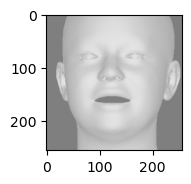

In [ ]:
class PLInference(pl.LightningModule):
    def __init__(self, deca_model, sample_fn):
        super(PLInference, self).__init__()
        self.deca_model=deca_model
        self.sample_fn = sample_fn

    def forward(self, noise):
        # seed_all(33)
        sample = self.sample_fn(
            model=self.deca_model,
            shape=(noise.shape[0], 159),
            noise=noise.cuda(),
            clip_denoised=args.clip_denoised,
        )
        return {"deca_output":sample}

# Normal Sampling 
init_noise = th.randn((1, 159)).cuda()
# init_noise = th.cat(([th.randn((1, 159)).cuda()] * args.batch_size), dim=0)
for i in range(3):
    print(init_noise)
    pl_inference = PLInference(deca_model=deca_model, sample_fn=diffusion.ddim_sample_loop)#p_sample_loop)
    sample_old = pl_inference(noise=init_noise)
    plot_deca(sample_old)

tensor([[ 0.0289,  0.0984,  0.6361, -0.6897, -0.3974, -0.5848, -0.6659,  1.6117,
         -0.5603, -1.3397,  1.6072,  0.4943, -0.9037,  0.8533,  1.8895, -0.0079,
         -0.0390,  0.3396, -0.2747,  1.3284, -1.1960,  0.9426, -1.5111,  1.5829,
          0.7940, -0.1960,  0.4601, -0.0110,  0.3313,  0.5896,  1.1232, -0.1838,
          0.1913,  0.7548,  1.2820,  0.7185, -1.3377, -0.7246,  0.4295, -1.2947,
         -0.0168, -2.2107, -0.0590,  1.0198, -0.2696, -1.3692, -1.5587,  0.2100,
          0.0092, -0.0042,  1.4209,  0.2295,  0.1016,  0.4598, -0.3351,  1.0176,
         -0.1771,  0.0902,  0.2261,  0.4059,  1.8733, -0.3440,  1.1985, -0.0704,
         -0.6099, -0.5858, -0.0071, -1.6059,  1.2559,  0.5403, -0.3488,  1.2503,
         -1.5248, -0.3688, -0.1803,  0.2376,  1.6018, -1.2883,  0.3877,  0.6961,
         -1.4186, -1.7071,  0.6823,  0.0971, -2.0875,  0.1388,  1.0061, -1.5186,
          0.6520, -0.2095, -0.8322,  1.2874, -0.6720,  1.3398,  1.4857,  0.6336,
          1.6497,  1.5549, -

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

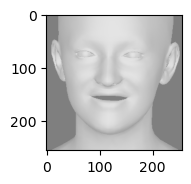

tensor([[ 0.0289,  0.0984,  0.6361, -0.6897, -0.3974, -0.5848, -0.6659,  1.6117,
         -0.5603, -1.3397,  1.6072,  0.4943, -0.9037,  0.8533,  1.8895, -0.0079,
         -0.0390,  0.3396, -0.2747,  1.3284, -1.1960,  0.9426, -1.5111,  1.5829,
          0.7940, -0.1960,  0.4601, -0.0110,  0.3313,  0.5896,  1.1232, -0.1838,
          0.1913,  0.7548,  1.2820,  0.7185, -1.3377, -0.7246,  0.4295, -1.2947,
         -0.0168, -2.2107, -0.0590,  1.0198, -0.2696, -1.3692, -1.5587,  0.2100,
          0.0092, -0.0042,  1.4209,  0.2295,  0.1016,  0.4598, -0.3351,  1.0176,
         -0.1771,  0.0902,  0.2261,  0.4059,  1.8733, -0.3440,  1.1985, -0.0704,
         -0.6099, -0.5858, -0.0071, -1.6059,  1.2559,  0.5403, -0.3488,  1.2503,
         -1.5248, -0.3688, -0.1803,  0.2376,  1.6018, -1.2883,  0.3877,  0.6961,
         -1.4186, -1.7071,  0.6823,  0.0971, -2.0875,  0.1388,  1.0061, -1.5186,
          0.6520, -0.2095, -0.8322,  1.2874, -0.6720,  1.3398,  1.4857,  0.6336,
          1.6497,  1.5549, -

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

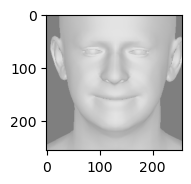

tensor([[ 0.0289,  0.0984,  0.6361, -0.6897, -0.3974, -0.5848, -0.6659,  1.6117,
         -0.5603, -1.3397,  1.6072,  0.4943, -0.9037,  0.8533,  1.8895, -0.0079,
         -0.0390,  0.3396, -0.2747,  1.3284, -1.1960,  0.9426, -1.5111,  1.5829,
          0.7940, -0.1960,  0.4601, -0.0110,  0.3313,  0.5896,  1.1232, -0.1838,
          0.1913,  0.7548,  1.2820,  0.7185, -1.3377, -0.7246,  0.4295, -1.2947,
         -0.0168, -2.2107, -0.0590,  1.0198, -0.2696, -1.3692, -1.5587,  0.2100,
          0.0092, -0.0042,  1.4209,  0.2295,  0.1016,  0.4598, -0.3351,  1.0176,
         -0.1771,  0.0902,  0.2261,  0.4059,  1.8733, -0.3440,  1.1985, -0.0704,
         -0.6099, -0.5858, -0.0071, -1.6059,  1.2559,  0.5403, -0.3488,  1.2503,
         -1.5248, -0.3688, -0.1803,  0.2376,  1.6018, -1.2883,  0.3877,  0.6961,
         -1.4186, -1.7071,  0.6823,  0.0971, -2.0875,  0.1388,  1.0061, -1.5186,
          0.6520, -0.2095, -0.8322,  1.2874, -0.6720,  1.3398,  1.4857,  0.6336,
          1.6497,  1.5549, -

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

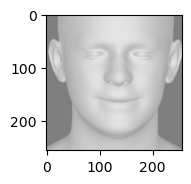

In [ ]:
# import pytorch_lightning as pl
class PLInference(pl.LightningModule):
    def __init__(self, deca_model, sample_fn):
        super(PLInference, self).__init__()
        self.deca_model=deca_model
        self.sample_fn = sample_fn

    def forward(self, noise):
        # seed_all(33)
        sample = self.sample_fn(
            model=self.deca_model,
            shape=(noise.shape[0], 159),
            noise=noise.cuda(),
            clip_denoised=args.clip_denoised,
        )
        return {"deca_output":sample}

# Normal Sampling 
init_noise = th.randn((1, 159)).cuda()
# init_noise = th.cat(([th.randn((1, 159)).cuda()] * args.batch_size), dim=0)
for i in range(3):
    print(init_noise)
    pl_inference = PLInference(deca_model=deca_model, sample_fn=diffusion.p_sample_loop)
    sample_old = pl_inference(noise=init_noise)
    plot_deca(sample_old)

In [ ]:
# Linearly Interpolate

pl_inference = PLInference(deca_model=deca_model, sample_fn='p_sample_loop')
r_interp = np.linspace(0, 1, num=10)
# src = th.randn(*(1, 159)).cuda()
# dst = th.randn(*(1, 159)).cuda()
src = init_noise[[0]].clone()
dst = init_noise[[1]].clone()
noise_interp = []
for r in r_interp:
    tmp = ((1-r) * src) + (r * dst)
    noise_interp.append(tmp.clone())

noise_interp = th.cat((noise_interp), dim=0)
sample_linear_interp = pl_inference(shape_dict={'deca':(noise_interp.shape[0], 159)}, noise=noise_interp)

# Convert a sampling parameters to 3D model

In [ ]:
plot_deca(sample)
# plot_deca(sample_linear_interp)

# Evaluate Generated data

## 1.Top-k parameters

In [ ]:
# KNN of parameters

def knn(x, y, k=10, params='all', dist_type='mse'):
    '''
    :x: = sampling (1, N-dim)
    :y: = train set (#samples, N-dim)
    e.g. N-dim = 159 for deca, (3, H, W) for image
    '''
    print(x.shape, y.shape)
    if 'all' in params:
        x=x; y=y
    else:
        all_x = []; all_y = []
        if 'shape' in params:
            all_x.append(x[..., :100])
            all_y.append(y[..., :100])
        if 'pose' in params:
            all_x.append(x[..., 100:106])
            all_y.append(y[..., 100:106])
        if 'exp' in params:
            all_x.append(x[..., 106:156])
            all_y.append(y[..., 106:156])
        if 'cam' in params:
            all_x.append(x[..., 156:])
            all_y.append(y[..., 156:])

        x = th.cat(all_x, dim=1)
        y = th.cat(all_y, dim=1)

    dist = distance(x=x, y=y, dist_type=dist_type)
    _, idx = th.topk(input=dist, k=k, largest=False)

    return idx


def distance(x, y, dist_type='mse'):
    '''
    :x: = sampling (1, N-dim)
    :y: = train set (#samples, N-dim)
    e.g. N-dim = 159 for deca, (3, H, W) for image

    return 
    :dist: (#samples,)
    
    '''
    if dist_type == 'mse':
        dist = th.mean((x - y)**2, dim=1)

    elif dist_type == 'mae':
        dist = th.mean(th.abs(x - y), dim=1)

    else: raise NotImplementedError
    
    return dist

deca_sample = sample['deca_output']
# deca_sample = denormalize(deca_sample, min_val=th.tensor(min_val).cuda(), max_val=th.tensor(max_val).cuda(), a=-args.bound, b=args.bound).float()
deca_load_params = all_params
deca_load_params, _, _ = normalize(deca_load_params, a=-args.bound, b=args.bound)
deca_load_params = th.tensor(deca_load_params).cuda()
# deca_load_params = denormalize(deca_load_params, min_val=th.tensor(min_val).cuda(), max_val=th.tensor(max_val).cuda(), a=-args.bound, b=args.bound).float()

t_idx = 5
idx = knn(x=deca_sample[[t_idx]], y=deca_load_params, params=['pose'], dist_type='mae', k=15)
top_load = deca_load_params[idx.flatten()]

img_ = []
p = denormalize(deca_sample[t_idx].clone().cpu().numpy(), min_val=min_val, max_val=max_val, a=-args.bound, b=args.bound)
p = th.tensor(p, dtype=th.float).cuda()
shape = p[None, :100]
pose = p[None, 100:106]
exp = p[None, 106:156]
cam = p[None, 156:]
img = params_to_model(shape=shape, exp=exp, pose=pose, cam=cam, i=i)
img_.append(img["shape_images"])
from tqdm.auto import tqdm
for i in tqdm(range(top_load.shape[0])):
    p = top_load[i].clone().cpu().numpy()
    p = denormalize(p, min_val=min_val, max_val=max_val, a=-args.bound, b=args.bound)
    p = th.tensor(p, dtype=th.float).cuda()
    shape = p[None, :100]
    pose = p[None, 100:106]
    exp = p[None, 106:156]
    cam = p[None, 156:]
    img = params_to_model(shape=shape, exp=exp, pose=pose, cam=cam, i=i)
    img_.append(img["shape_images"])

plot_sample(th.cat(img_, dim=0))

## 2.FID-Score

In [ ]:
all_params

# Analysis of Face params

In [ ]:
img_dataset_path = '/data/mint/ffhq_256_with_anno/ffhq_256/train/'
img_name_list = [str(n) + '.jpg' for n in list(np.random.randint(0, 60000, 10))]

render_img_list = []
src_img_list = []
img_list = []
for img_name in img_name_list:
    shape = th.tensor(params_s[img_name]['shape'][None, :]).float().cuda()
    pose = th.tensor(params_s[img_name]['pose'][None, :]).float().cuda()
    exp = th.tensor(params_s[img_name]['exp'][None, :]).float().cuda()
    cam = th.tensor(params_s[img_name]['cam'][None, :]).float().cuda()

    src_img = PIL.Image.open(img_dataset_path + img_name)
    src_img = (th.tensor(np.transpose(src_img, (2, 0, 1)))[None, :] / 127.5) - 1
    src_img_list.append(src_img)

    render_img = params_to_model(shape=shape, exp=exp, pose=pose, cam=cam, i=img_name)
    render_img_list.append(render_img["shape_images"])

src_img = th.cat(src_img_list, dim=0)
render_img = th.cat(render_img_list, dim=0)
plot_sample(img=src_img, render_img=render_img)

In [ ]:
def simple_analyse(params, key, sample_params=None):
    '''
    :params: tensor in shape BxD
    '''
    fig = plt.figure(figsize=(5, 5), dpi=100)
    plt.bar(x=np.arange(params.shape[-1]), height=np.max(params, axis=0)-np.min(params, axis=0), bottom=np.min(params, axis=0), color=(0, 0, 1, 0.25), label="Train set")


    if sample is not None:
        plt.bar(x=np.arange(sample_params.shape[-1]), height=np.max(sample_params, axis=0)-np.min(sample_params, axis=0), bottom=np.min(sample_params, axis=0), color=(1, 0, 0, 0.5), label="Sampling")

    plt.legend()
    fig.show()

import plotly.figure_factory as ff

# def dist_analyse(params, key, sample_params=None):
#     group_labels = [f'comp-{i}' for i in range(params.shape[-1])]
#     hist_data_params = [params[:, i] for i in range(params.shape[-1])]
#     fig = ff.create_distplot(hist_data_params, group_labels, show_rug=False)
#     fig.write_html(f"./{key}-dist.html")

sample_params = {'shape':[], 'pose':[], 'exp':[], 'cam':[]}
for i in range(sample["deca_output"].shape[0]):
    deca_params = sample["deca_output"][i].clone()
    deca_params = denormalize(deca_params, min_val=th.tensor(min_val).cuda(), max_val=th.tensor(max_val).cuda(), a=-args.bound, b=args.bound).float()
    shape = deca_params[None, :100].cpu().numpy()
    pose = deca_params[None, 100:106].cpu().numpy()
    exp = deca_params[None, 106:156].cpu().numpy()
    cam = deca_params[None, 156:].cpu().numpy()
    sample_params['shape'].append(shape)
    sample_params['pose'].append(pose)
    sample_params['exp'].append(exp)
    sample_params['cam'].append(cam)

for k in sample_params.keys():
    sample_params[k] = np.concatenate(sample_params[k], axis=0)

params_list = ['shape', 'pose', 'exp', 'cam']
# params_list = ['cam']
for each_p in params_list:
    p = np.concatenate([params_s[k][each_p][None, :] for k in params_s.keys()], axis=0)
    simple_analyse(params=p, key=each_p, sample_params=sample_params[each_p])
    # dist_analyse(params=p, key=each_p, sample_params=sample_params[each_p])